In [1]:
import os
import json
from itertools import groupby
from torch.optim import Adam
from torch.nn import functional as nnf
from torchvision.transforms import functional as transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
from torch import nn

import matplotlib.pyplot as plt

import numpy as np
from os.path import join, isdir, expanduser
from PIL import Image

data_path = expanduser('~/datasets')

In [13]:
batch_size = 16

A_train = torch.load("A.pt")
B_train = torch.load("B.pt")

A_loader_train = torch.utils.data.DataLoader(A_train, batch_size=batch_size, shuffle=True, drop_last=True)
B_loader_train = torch.utils.data.DataLoader(B_train, batch_size=batch_size, shuffle=True, drop_last=True)

A_test = torch.load("A_test.pt")
B_test = torch.load("B_test.pt")

A_loader_test = torch.utils.data.DataLoader(A_test, batch_size=10, shuffle=True, drop_last=True)
B_loader_test = torch.utils.data.DataLoader(B_test, batch_size=10, shuffle=True, drop_last=True)

In [3]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        conv1 = nn.Conv2d(channels, channels, 3)
        bn1 = nn.BatchNorm2d(channels)
        relu = nn.ReLU()
        conv2 = nn.Conv2d(channels, channels, 3)
        bn2 = nn.BatchNorm2d(channels)
        
        self.Layers = nn.Sequential(conv1, bn1, relu, conv2, bn2)
        
    def forward(self, x):
        x_crop = x[:,:,2:-2,2:-2]
        return self.Layers(x) + x_crop

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.padder =  nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        
        self.resblocks = nn.Sequential(*[ResBlock(128) for _ in range(5)])
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size= 2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size= 2, stride=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size= 9, stride=1, padding="same")
    
    def forward(self, x):
        for layer in [self.padder, self.conv1, self.conv2, self.conv3]:
            x = layer(x)
            
        x =  self.resblocks(x)
        
        x = nn.Tanh()(self.conv4(self.upconv2(self.upconv1(x))))
        
        return x
    
class Discriminator(nn.Module):
    
    def __init__(self, d=64):
        super().__init__()
        
        self.lrelu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
       
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(d * 8,1)
        self.sig = nn.Sigmoid()
        
        
        

    def forward(self, x):
        
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2_bn(self.conv2(x)))
        x = self.lrelu(self.conv3_bn(self.conv3(x)))
        x = self.lrelu(self.conv4_bn(self.conv4(x)))
        
        x = self.sig((self.linear(self.flatten(self.pool(x)))))

        return x

In [4]:
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, Compose, InterpolationMode

transform_pipeline = Compose([
    RandomCrop(200),
    RandomHorizontalFlip(p=0.5),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Resize(128, InterpolationMode.BICUBIC)
])

def unprocess(img):
    img = img.permute(1,2,0)
    img = img - img.min()
    return img / img.max()

def show(images):
    l = len(images)
   
    _, axs = plt.subplots(1, l, figsize=(15,7))
    for i, img in enumerate(images):
        axs[i].imshow(unprocess(img))
        axs[i].axis('off')
    plt.show()

In [8]:
def load(folderpath):
    G_ab = Generator().cuda()
    G_ba = Generator().cuda()

    D_a = Discriminator(d=128).cuda()
    D_b = Discriminator(d=128).cuda()
    
    G_ab.load_state_dict(torch.load(os.path.join(folderpath, "G_ab.pt")))
    G_ba.load_state_dict(torch.load(os.path.join(folderpath, "G_ba.pt")))
    D_a.load_state_dict(torch.load(os.path.join(folderpath, "D_a.pt")))
    D_b.load_state_dict(torch.load(os.path.join(folderpath, "D_b.pt")))
                         
    return G_ab, G_ba, D_a, D_b
                         

G_ab, G_ba, D_a, D_b = load(os.path.join("saves", "01", "06.05._13:40"))                   

# Training translation

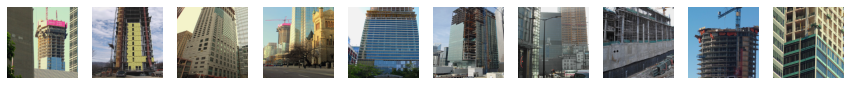

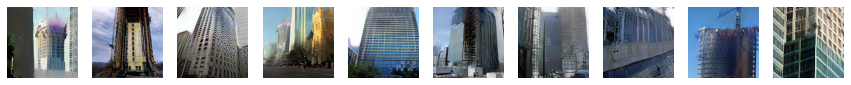

In [14]:
train_a = next(iter(A_loader_train))
train_a = transform_pipeline(train_a)

show(train_a[:10])

res = G_ab(train_a[:10].cuda()).cpu().detach()
show(res)

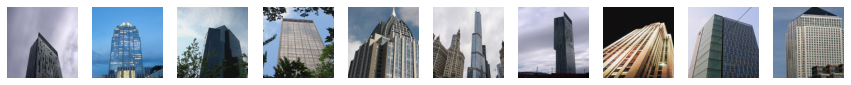

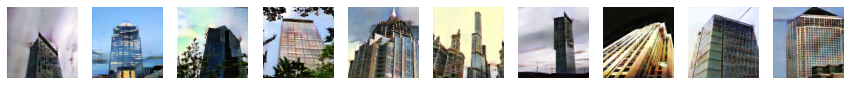

In [15]:
train_b = next(iter(B_loader_train))
train_b = transform_pipeline(train_b)

show(train_b[:10])

res = G_ba(train_b[:10].cuda()).cpu().detach()
show(res)

# Testing Translation

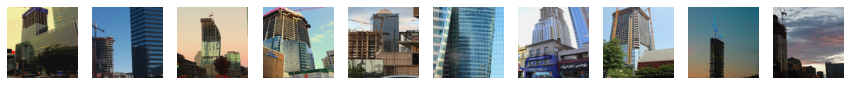

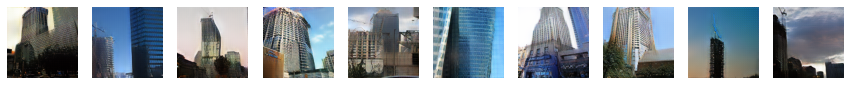

In [16]:
test_a = next(iter(A_loader_test))
test_a = transform_pipeline(test_a)

show(test_a[:10])

res = G_ab(test_a[:10].cuda()).cpu().detach()
show(res)

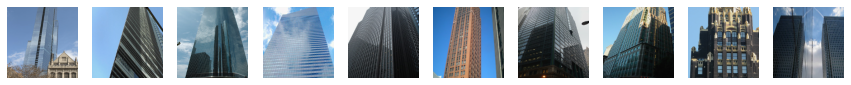

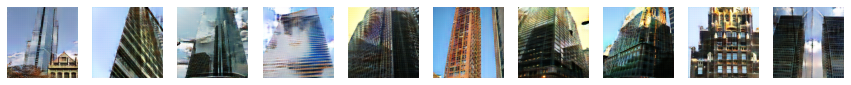

In [18]:
test_b = next(iter(B_loader_test))
test_b = transform_pipeline(test_b)

show(test_b[:10])

res = G_ba(test_b[:10].cuda()).cpu().detach()
show(res)